# Actor Critic with OpenAI Gym


This tutorial was inspired by [Outlace's excelent blog entry on Q-Learning](http://outlace.com/Reinforcement-Learning-Part-3/) and this is the [starting point](https://www2.informatik.uni-hamburg.de/~weber/code/ActorCritic.py) for my Actor Critic implementation. I highly recommend you read his three tutorials on Reinforcement Learning first.

I got interested in Actor-Critic reinforcement learning after skimming DeepMind's follow-up to their original Atari paper. The new paper [Asynchronous Methods for Deep Reinforcement Learning](http://arxiv.org/abs/1602.01783) uses an Actor/Critic learning implementation to surpass the performance of their original Deep Q-Network. I couldn't find a good straightforward implementation/example of it.

For a slightly more in-depth explination check out [Actor-Critic Methods](https://webdocs.cs.ualberta.ca/~sutton/book/ebook/node66.html) from the book 'Reinforcement Learning: An Introduction' by Sutton and Barto

This will be a basic example of using Actor Critic methods to solve a simple reinforcement learning problem from OpenAI Gym

Couple thing's we have here:

* Actor Critic
* Neural Networks as Function Approximators for both Actor and Critic
* Experience Replay to avoid catastrophic forgetting

If you are running the ipython notebook this tutorial expects you to have [OpenAI Gym](https://gym.openai.com/docs) and [Keras](https://github.com/fchollet/keras) installed. [The Notebook is available from GitHub](https://github.com/gregretkowski/notebooks/blob/master/ActorCritic-with-OpenAI-Gym.ipynb).

## Lets get to coding...

We are going to start off with some bookkeeping - importing the components we need.

In [1]:
%pylab inline
# Just some initial setup and imports
import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)
from IPython.display import clear_output
import time
import numpy as np
import math
import gym

Populating the interactive namespace from numpy and matplotlib


For the environment our agent is going to interact with we'll use the OpenAI Gym, and use a variation of an existing environment 'Frozen Lake' - however we're going to make a version which does not include slippery ice. This simplification will make it much easier to visualize what's happening within our Actor/Critic implementation.

In [2]:
# Create a non-skid version of Frozen Lake
from gym.envs.registration import register, spec

MY_ENV_NAMES = ['FrozenLakeNonskid4x4-v0', 'FrozenLakeNonskid8x8-v0']
map_names = ['4x4', '8x8']

envs = []
for MY_ENV_NAME, map_name in zip(MY_ENV_NAMES, map_names):
    try:
        spec(MY_ENV_NAME)
    except:
        register(
            id=MY_ENV_NAME,
            entry_point='gym.envs.toy_text:FrozenLakeEnv',
            kwargs={'map_name': map_name, 'is_slippery': False},
            timestep_limit=100,
            reward_threshold=0.78, # optimum = .8196
        )
    envs.append(gym.make(MY_ENV_NAME))

[2016-08-30 08:34:36,110] Making new env: FrozenLakeNonskid4x4-v0
[2016-08-30 08:34:36,120] Making new env: FrozenLakeNonskid8x8-v0


I'll define some constants, to make the code clearer and easier later. The constants ```OBSERVATION_SPACE``` and ```ACTION_SPACE``` come from OpenAI gym. For this problem each of these is just a single integer. I then define a constant ```OBS_SQR``` and ```STATEGRID``` which will help when we create visualizations showing the square grid of our gridworld. These constants are not needed for the learner.

Finally I create a helper which will allow us to convert the observation from OpenAI Gym, from an integer, like 64, to a one-hot encoding - which is better for a neural network to consume.


In [3]:
env = envs[0]
# This helper is for later. 
def to_onehot(size,value):
  my_onehot = np.zeros((size))
  my_onehot[value] = 1.0
  return my_onehot.reshape(1, size)

OBSERVATION_SPACE = env.observation_space.n
ACTION_SPACE = env.action_space.n

# Assume gridworld is always square
OBS_SQR= int(math.sqrt(OBSERVATION_SPACE))
STATEGRID = np.zeros((OBS_SQR,OBS_SQR))

### The Actor

In Actor/Critic there are two networks. The Policy network (the Actor) and the Value network (the Critic). You will recognize the policy network as being essentially the same as the network from the Q-Learning example referenced above.

In [4]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop, SGD

actor_model = Sequential()
actor_model.add(Dense(164, init='lecun_uniform', input_shape=(OBSERVATION_SPACE,)))
actor_model.add(Activation('relu'))

actor_model.add(Dense(150, init='lecun_uniform'))
actor_model.add(Activation('relu'))

actor_model.add(Dense(ACTION_SPACE, init='lecun_uniform'))
actor_model.add(Activation('softmax'))

a_optimizer = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
actor_model.compile(loss='categorical_crossentropy', optimizer=a_optimizer)

Using TensorFlow backend.


### The Critic
Next, we set up the Critic network. This network looks very similar to the Actor model, but only outputs a single value - it outputs a value (the score) for the input state.

In [6]:
critic_model = Sequential()

critic_model.add(Dense(164, init='lecun_uniform', input_shape=(OBSERVATION_SPACE,)))
critic_model.add(Activation('relu'))
critic_model.add(Dense(150, init='lecun_uniform'))
critic_model.add(Activation('relu'))
critic_model.add(Dense(1, init='lecun_uniform'))
critic_model.add(Activation('linear'))

c_optimizer = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
critic_model.compile(loss='mse', optimizer=c_optimizer)

Now we'll add a nice helper function to show what value the Critic gives to being in certain states. The critic starts out uninitialized and will just give random values for any given state.

In [7]:
STATEGRID

array([[ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])

SFFF
FHFH
FFFH
HFFG



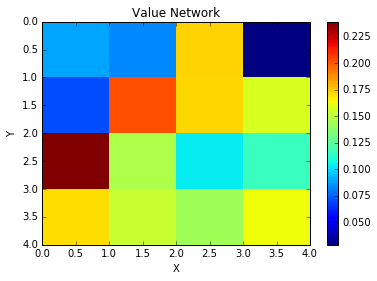

In [8]:
# Plot out the values the critic gives for the agent being in
# a specific state, i.e. in a specific location in the env.
def plot_value(initial_state):
    # Assume gridworld is always a square
    obs_sqr = math.sqrt(OBSERVATION_SPACE)
    np_w_cri_r = np.zeros((OBS_SQR,OBS_SQR))
    # make a working copy.
    working_state = initial_state.copy()
    for x in range(0,OBS_SQR):
        for y in range(0,OBS_SQR):
            my_state = working_state.copy()
            # Place the player at a given X/Y location.
            my_state[x,y] = 1
            # And now have the critic model predict the state value
            # with the player in that location.
            value = critic_model.predict(my_state.reshape(1, OBSERVATION_SPACE))
            np_w_cri_r[x,y] = value
    np_w_cri_r.shape
    pylab.pcolor(np_w_cri_r)
    pylab.title("Value Network")
    pylab.colorbar()
    pylab.xlabel("X")
    pylab.ylabel("Y")
    pylab.gca().invert_yaxis()
    pylab.draw()


env.reset()
env.render()
plot_value(STATEGRID)

This may not be necessary, or even possible in all cases - but in this case we can zero-out the Critic network, so that all states start with a value of Zero. This should help it converge later when it sees real training data.

Zeroing out critic network...
Done!


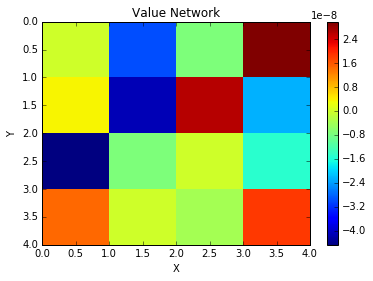

In [18]:
def zero_critic(epochs=100):
    for i in range(epochs):
        X_train = []
        y_train = []
        for j in range(OBSERVATION_SPACE):

            
            y = np.empty([1])
            y[0]=0.0
            x = to_onehot(OBSERVATION_SPACE,j)
            X_train.append(x.reshape((OBSERVATION_SPACE,)))
            y_train.append(y.reshape((1,)))
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        critic_model.fit(X_train, y_train, batch_size=OBSERVATION_SPACE, nb_epoch=10, verbose=0)

print("Zeroing out critic network...")
sys.stdout.flush()
zero_critic()
print("Done!")
plot_value(STATEGRID)

# The Trainer

The trainer is implemented below. 

The big main new things here are the split of the Critic network (state values) from the Actor (action selection).

To train the critic network, we use a simlar process to training value into Q networks. We look at the initial state, make a move, and then look at the new state. For the value network, if we are in a terminal state, that's the value we tell the value network to place on that state. If we are in a non-terminal state, we tell the value network to place a value on the original state which is the reward in the original state, plus the discounted value from the new state. ~~Note that the value network should return the maximum possible value for a given state. If the player's next move could be either jumping into the pit or arriving at the goal, we should set the value as if the best-possible action will be selected.~~

After the critic network has assigned a value to the original and the new state, we adjust the policy. This is simply by looking at our value in our old state, and the value in the new state. If the value improves we encourage that action. If it decreases we discourage the action.

When we start training, both the actor and the critic networks are spitting out nonsensical values. Which means initially the actor network is training on values from the critic network which are garbage. However as the critic network improves, those improvements naturally correct and improve the performance of the actor network.

The Experience Replay is essentially the same as the example in the Q-learning tutorial. However we replay both the Actor and the Critic's experiences.


In [25]:
import keras
def get_trainable_params(model):
    params = []
    for layer in model.layers:
        params += keras.engine.training.collect_trainable_weights(layer)
    return params

In [27]:
network_params = get_trainable_params(actor_model)

In [29]:
import tensorflow as tf
param_grad = tf.gradients(cost, network_params)

NameError: name 'cost' is not defined

In [30]:
tf.gradients?

In [17]:
from IPython.display import clear_output
import random
import time

def simple_online_actor_critic(epochs=1000, batchSize=40, 
                               gamma=0.975, epsilon=1, min_epsilon=0.1,
                               buffer=80):
    
    wins = 0
    losses = 0
    # Replay buffers
    actor_replay = []
    critic_replay = []
    
    for i in range(epochs):

        observation = env.reset()
        done = False
        reward = 0
        info = None
        move_counter = 0
        alpha = 0.1

        while(not done):
            # Get original state, original reward, and critic's value for this state.
            orig_state = to_onehot(OBSERVATION_SPACE, observation)
            orig_val = critic_model.predict(orig_state)
            
            # select actions
            action_probs = actor_model.predict(orig_state)
            action = np.random.multinomial(1, action_probs).argmax()
            
            #Take action, observe new state S'
            new_observation, reward, done, info = env.step(action)
            new_state = to_onehot(OBSERVATION_SPACE, new_observation)
            
            # Critic's value for this new state.
            new_val = critic_model.predict(new_state)
            
            if not done: # Non-terminal state.
                target = reward + gamma * new_val - orig_val
            else:
                # In terminal states, the environment tells us
                # the value directly.
                target = reward - orig_val
            
            critic_replay.append([orig_state, target])
            
            # Build the update for the Actor. The actor is updated
            # by using the difference of the value the critic
            # placed on the old state vs. the value the critic
            # places on the new state.. encouraging the actor
            # to move into more valuable states.
            actor_delta = new_val - orig_val                
            actor_replay.append([orig_state, action, actor_delta])
                    
            # Critic Replays...
            while(len(critic_replay) > buffer): # Trim replay buffer
                critic_replay.pop(0)
            # Start training when we have enough samples.
            if(len(critic_replay) >= buffer):
                minibatch = random.sample(critic_replay, batchSize)
                X_train = []
                y_train = []
                for memory in minibatch:
                    m_state, m_value = memory
                    y = np.empty([1])
                    y[0] = m_value
                    X_train.append(m_state.reshape((OBSERVATION_SPACE,)))
                    y_train.append(y.reshape((1,)))
                X_train = np.array(X_train)
                y_train = np.array(y_train)
                critic_model.fit(X_train, y_train, batch_size=batchSize, nb_epoch=1, verbose=0)
            
            # Actor Replays...
            while(len(actor_replay) > buffer):
                actor_replay.pop(0)                
            if(len(actor_replay) >= buffer):
                X_train = []
                y_train = []
                minibatch = random.sample(actor_replay, batchSize)
                for memory in minibatch:
                    m_orig_state, m_action, m_value = memory
                    old_qval = actor_model.predict( m_orig_state.reshape(1,OBSERVATION_SPACE,) )
                    y = np.zeros(( 1, ACTION_SPACE ))
                    y[:] = old_qval[:]
                    y[0][m_action] = m_value
                    X_train.append(m_orig_state.reshape((OBSERVATION_SPACE,)))
                    y_train.append(y.reshape((ACTION_SPACE,)))
                X_train = np.array(X_train)
                y_train = np.array(y_train)
                actor_model.fit(X_train, y_train, batch_size=batchSize, nb_epoch=1, verbose=0)

            # Bookkeeping at the end of the turn.
            observation = new_observation
            reward = new_reward
            move_counter+=1
            if done:
                if new_reward > 0 : # Win
                    wins += 1
                else: # Loss
                    losses += 1
        # Finised Epoch
        clear_output(wait=True)
        print("Game #: %s" % (i,))
        print("Moves this round %s" % move_counter)
        print("Final Position:")
        env.render()
        print("Wins/Losses %s/%s" % (wins, losses))
        if epsilon > min_epsilon:
            epsilon -= (1/epochs)


In [18]:
from IPython.display import clear_output
import random
import time

def trainer(epochs=1000, batchSize=40, 
            gamma=0.975, epsilon=1, min_epsilon=0.1,
            buffer=80):
    
    wins = 0
    losses = 0
    # Replay buffers
    actor_replay = []
    critic_replay = []
    
    for i in range(epochs):

        observation = env.reset()
        done = False
        reward = 0
        info = None
        move_counter = 0

        while(not done):
            # Get original state, original reward, and critic's value for this state.
            orig_state = to_onehot(OBSERVATION_SPACE, observation)
            orig_reward = reward
            orig_val = critic_model.predict(orig_state.reshape(1, OBSERVATION_SPACE))

            if (random.random() < epsilon): #choose random action
                action = np.random.randint(0,ACTION_SPACE)
            else: #choose best action from Q(s,a) values
                qval = actor_model.predict( orig_state.reshape(1,OBSERVATION_SPACE) )
                action = (np.argmax(qval))
                
            #Take action, observe new state S'
            new_observation, new_reward, done, info = env.step(action)
            new_state = to_onehot(OBSERVATION_SPACE,new_observation)
            # Critic's value for this new state.
            new_val = critic_model.predict(new_state.reshape(1,OBSERVATION_SPACE))
            
            if not done: # Non-terminal state.
                target = orig_reward + ( gamma * new_val)
            else:
                # In terminal states, the environment tells us
                # the value directly.
                target = orig_reward + ( gamma * new_reward )
            
            # For our critic, we select the best/highest value.. The
            # value for this state is based on if the agent selected
            # the best possible moves from this state forward.
            # 
            # BTW, we discount an original value provided by the
            # value network, to handle cases where its spitting
            # out unreasonably high values.. naturally decaying
            # these values to something reasonable.
            best_val = max((orig_val*gamma), target)

            # Now append this to our critic replay buffer.
            critic_replay.append([orig_state,best_val])
            # If we are in a terminal state, append a replay for it also.
            if done:
                critic_replay.append( [new_state, float(new_reward)] )
            
            # Build the update for the Actor. The actor is updated
            # by using the difference of the value the critic
            # placed on the old state vs. the value the critic
            # places on the new state.. encouraging the actor
            # to move into more valuable states.
            actor_delta = new_val - orig_val                
            actor_replay.append([orig_state, action, actor_delta])
                    
            # Critic Replays...
            while(len(critic_replay) > buffer): # Trim replay buffer
                critic_replay.pop(0)
            # Start training when we have enough samples.
            if(len(critic_replay) >= buffer):
                minibatch = random.sample(critic_replay, batchSize)
                X_train = []
                y_train = []
                for memory in minibatch:
                    m_state, m_value = memory
                    y = np.empty([1])
                    y[0] = m_value
                    X_train.append(m_state.reshape((OBSERVATION_SPACE,)))
                    y_train.append(y.reshape((1,)))
                X_train = np.array(X_train)
                y_train = np.array(y_train)
                critic_model.fit(X_train, y_train, batch_size=batchSize, nb_epoch=1, verbose=0)
            
            # Actor Replays...
            while(len(actor_replay) > buffer):
                actor_replay.pop(0)                
            if(len(actor_replay) >= buffer):
                X_train = []
                y_train = []
                minibatch = random.sample(actor_replay, batchSize)
                for memory in minibatch:
                    m_orig_state, m_action, m_value = memory
                    old_qval = actor_model.predict( m_orig_state.reshape(1,OBSERVATION_SPACE,) )
                    y = np.zeros(( 1, ACTION_SPACE ))
                    y[:] = old_qval[:]
                    y[0][m_action] = m_value
                    X_train.append(m_orig_state.reshape((OBSERVATION_SPACE,)))
                    y_train.append(y.reshape((ACTION_SPACE,)))
                X_train = np.array(X_train)
                y_train = np.array(y_train)
                actor_model.fit(X_train, y_train, batch_size=batchSize, nb_epoch=1, verbose=0)

            # Bookkeeping at the end of the turn.
            observation = new_observation
            reward = new_reward
            move_counter+=1
            if done:
                if new_reward > 0 : # Win
                    wins += 1
                else: # Loss
                    losses += 1
        # Finised Epoch
        clear_output(wait=True)
        print("Game #: %s" % (i,))
        print("Moves this round %s" % move_counter)
        print("Final Position:")
        env.render()
        print("Wins/Losses %s/%s" % (wins, losses))
        if epsilon > min_epsilon:
            epsilon -= (1/epochs)


We'll now train the Actor/Critic for a number of epoch's which seems to give decent results.

In [19]:
%%time
trainer()

Game #: 999
Moves this round 11
Final Position:
SFFF
FHFH
FFFH
HFFG
  (Right)
Wins/Losses 20/980
CPU times: user 58.3 s, sys: 4min 1s, total: 5min
Wall time: 3min 12s


Now we can examine what the value network has learned - and the values it has placed on any given location on the board.

SFFF
FHFH
FFFH
HFFG
  (Right)


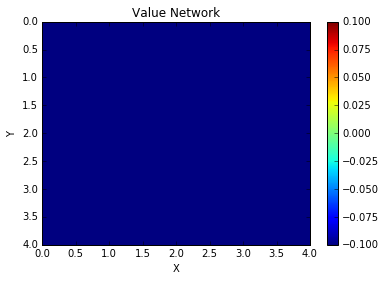

In [20]:
env.reset()
env.render()
plot_value(STATEGRID)


We can see that the value network has placed a high value on the winning final position. That value equaling the reward gained when in that position. It also places a very low value on the 'hole' positions. Makes sense. Then we can see that the network places ever growing value on positions which move us closer to the winning position. Thus the value network can express to the policy network that a move which moves us closer to the winning position is more valuable. Lets take a look at what the policy network has learned.

In [22]:
# Maps actions to arrows to indicate move direction.
A2A=['<','v','>','^']
def show_policy(initial_state):
    grid = np.zeros((OBS_SQR,OBS_SQR), dtype='<U2')
    #working_state = initial_state.copy()
    #p = findLoc(working_state, np.array([0,0,0,1]))
   #working_state[p[0],p[1]] = np.array([0,0,0,0])
    for x in range(0,OBS_SQR):
        for y in range(0,OBS_SQR):
            #for a in range(0, 4):
            my_state = initial_state.copy()
            my_state[x,y] = 1
            #
            obs_predict = my_state.reshape(1,OBSERVATION_SPACE,)
            qval = actor_model.predict(obs_predict)
            #print(obs_predict)
            
            action = (np.argmax(qval))
            grid[x,y] = A2A[action]
    grid
    return grid

env.reset()
env.render()
print(show_policy(STATEGRID))

SFFF
FHFH
FFFH
HFFG
  (Left)
[[u'<' u'<' u'<' u'<']
 [u'<' u'<' u'<' u'<']
 [u'<' u'<' u'<' u'<']
 [u'<' u'<' u'<' u'<']]


Now we'll have our learner show us what it has learned. It is important to note, that when testing, we only need the actor/policy network. The critic network is not involved. The Actor has learned the correct policy/moves as it trains on the values supplied by the critic network.

In [23]:
def play(render_every_step=False):
    observation = env.reset()
    done = False
    reward = 0.0
    max_moves = 40
    move_counter = 0
    while not done and move_counter < max_moves:
        state = to_onehot(OBSERVATION_SPACE,observation)
        qval = actor_model.predict( state.reshape(1,OBSERVATION_SPACE) )
        action = (np.argmax(qval))
        observation, reward, done, info = env.step(action)
        print(A2A[action])
        if render_every_step:
            env.render()
        move_counter += 1
    env.render()

play(render_every_step=True)

<
SFFF
FHFH
FFFH
HFFG
  (Left)
<
SFFF
FHFH
FFFH
HFFG
  (Left)
<
SFFF
FHFH
FFFH
HFFG
  (Left)
<
SFFF
FHFH
FFFH
HFFG
  (Left)
<
SFFF
FHFH
FFFH
HFFG
  (Left)
<
SFFF
FHFH
FFFH
HFFG
  (Left)
<
SFFF
FHFH
FFFH
HFFG
  (Left)
<
SFFF
FHFH
FFFH
HFFG
  (Left)
<
SFFF
FHFH
FFFH
HFFG
  (Left)
<
SFFF
FHFH
FFFH
HFFG
  (Left)
<
SFFF
FHFH
FFFH
HFFG
  (Left)
<
SFFF
FHFH
FFFH
HFFG
  (Left)
<
SFFF
FHFH
FFFH
HFFG
  (Left)
<
SFFF
FHFH
FFFH
HFFG
  (Left)
<
SFFF
FHFH
FFFH
HFFG
  (Left)
<
SFFF
FHFH
FFFH
HFFG
  (Left)
<
SFFF
FHFH
FFFH
HFFG
  (Left)
<
SFFF
FHFH
FFFH
HFFG
  (Left)
<
SFFF
FHFH
FFFH
HFFG
  (Left)
<
SFFF
FHFH
FFFH
HFFG
  (Left)
<
SFFF
FHFH
FFFH
HFFG
  (Left)
<
SFFF
FHFH
FFFH
HFFG
  (Left)
<
SFFF
FHFH
FFFH
HFFG
  (Left)
<
SFFF
FHFH
FFFH
HFFG
  (Left)
<
SFFF
FHFH
FFFH
HFFG
  (Left)
<
SFFF
FHFH
FFFH
HFFG
  (Left)
<
SFFF
FHFH
FFFH
HFFG
  (Left)
<
SFFF
FHFH
FFFH
HFFG
  (Left)
<
SFFF
FHFH
FFFH
HFFG
  (Left)
<
SFFF
FHFH
FFFH
HFFG
  (Left)
<
SFFF
FHFH
FFFH
HFFG
  (Left)
<
SFFF
FHFH
FFFH
HFFG
  (Left)
<
SFFF
F

## Conclusion

We've demonstrated using an actor-critic learner to solve a toy gridworld problem. I hope this serves as a good jumping off point for folks trying to understand Actor/Critic, or other RL methods which separate the Policy network from the Value network. If you have questions or comments please leave them below!
